#### Here's the latest attempt to run pyFSM2.fsm2_standalone identical to the FSM2

In [1]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
pyAPES_main_folder = os.getenv('pyAPES_main_folder')
sys.path.append(pyAPES_main_folder)

from pyAPES.snow.pyFSM2.fsm2_standalone_new import FSM2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from datetime import datetime
from pyAPES.parameters.mlm_parameters import snow

In [2]:
fforc = r'/Users/jpnousu/FSM2/met_Sod_1314.txt'
fout = r'/Users/jpnousu/FSM2/Sod_1314_stat.txt'
foutf = r'/Users/jpnousu/FSM2/Sod_1314_flux.txt'
forcing = pd.read_csv(fforc, header=None, delimiter=r"\s+", index_col=0, parse_dates={'time': [0,1,2,3]}, date_parser=lambda x: datetime.strptime(x, '%Y %m %d %H'))
out = pd.read_csv(fout, header=None, delimiter=r"\s+")
outf = pd.read_csv(foutf, header=None, delimiter=r"\s+")
col_names = ['DIR_SWdown', 'LWin', 'Prec_ice', 'Prec_liquid', 'Tair', 'RH', 'U', 'P']
forcing.columns = col_names

/var/folders/01/f14lxpfj5wl28zjtf5rz8t9c0000gn/T/ipykernel_96805/2870744076.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  forcing = pd.read_csv(fforc, header=None, delimiter=r"\s+", index_col=0, parse_dates={'time': [0,1,2,3]}, date_parser=lambda x: datetime.strptime(x, '%Y %m %d %H'))


In [3]:
snow['fsm2']['physics_options']['EXCHNG'] = 1

snowpack = FSM2(snow['fsm2'])


# Looping over the forcing file, running forestfloor and soil models for each timestep and saving the results
results = []  # collect rows here

for index, row in forcing.iterrows():

    ###### Inputs for forestfloor (based on how they are used in mlm_canopy.py)
    snow_forcing = {  # Reset the dictionary for each iteration
        'Rf': row['Prec_liquid'], # kg m-2 s-1
        'Sf': row['Prec_ice'], # kg m-2 s-1
        'Ua': row['U'], # m/s
        'SWsrf': row['DIR_SWdown'],  # Total [W m-2]
        'LW': row['LWin'],  # Longwave downward radiation [W m-2]
        'Ta': row['Tair'],  # Air temperature [degC]
        'Ps': row['P'],  # Air pressure [Pa]
        'RH': row['RH'], # Relative humidity
        'reference_height': 10.,
    }
    snow_params = {
        'reference_height': 18.0,
    }
    # --- solve forestfloor
    snow_fluxes, snow_states = snowpack.run(
                dt=3600,
                forcing=snow_forcing,
                )
    
    # --- update forestfloor
    snowpack.update()

    # --- flatten into one dict
    row_result = {
        "time": index,   # or row["time"] if you have a column with timestamps
        **{f"flux_{k}": v for k, v in snow_fluxes.items()},
        **{f"state_{k}": v for k, v in snow_states.items()},
    }

    results.append(row_result)

# Convert to DataFrame
results_df = pd.DataFrame(results)

Text(0, 0.5, 'Snow depth [m]')

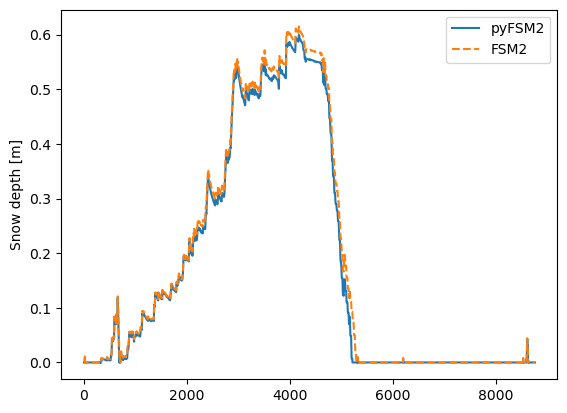

In [4]:
plt.plot(results_df['state_snow_depth'].values, label='pyFSM2')
plt.plot(out.iloc[:,4].values, linestyle='--', label='FSM2')
plt.legend()
plt.ylabel('Snow depth [m]')